# Global and Local Explanation for KNN model on MIT data


Input files:  
Mode: `model_mit_knn.pkl` generated in notebook `modeling_mit_knn.ipynb`     

Dataset: Binary classification datate genereted in notebook `preprocessing_mit_minmax_oversampling.ipynb`  
'mitbih_train_clean_minmax_oversampling.csv'  
'mitbih_test_clean_minmax_oversamling.csv'

In [5]:
import sys
import os 

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab 

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    model_output_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


In [6]:
# Verify installation and import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
import pickle
from sklearn.model_selection import train_test_split
import os
import shap

In [7]:
RawFiles = dict({
    'train': data_path + 'mitbih_train_clean_minmax_oversampling.csv', 
    'test': data_path + 'mitbih_test_clean_minmax_oversampling.csv'  
})

train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)
test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)

load model

In [8]:
# Define model_path based on model_output_path
model_path = model_output_path + 'model_mit_knn.pkl'

# Load the pipeline model from the pickle file
with open(model_path, 'rb') as file:
    pipeline_model = pickle.load(file)

# Check the type of the model (pipeline)
print(f"Model type: {type(pipeline_model)}")

# Print the names of the pipeline steps
print("Pipeline steps (names and objects):")
for step_name, step_obj in pipeline_model.named_steps.items():
    print(f"{step_name}: {type(step_obj)}")

# Alternatively, you can get the dictionary of steps directly:
steps_dict = pipeline_model.named_steps
print("Available steps in the pipeline:", steps_dict.keys())


Model type: <class 'imblearn.pipeline.Pipeline'>
Pipeline steps (names and objects):
model: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Available steps in the pipeline: dict_keys(['model'])


### In the following we apply explanation strategies (Feature Importance, SHAP, LIME) on the resampled (Oversampling) and rescaled (MinMax Scaler) dataset to explain the most important features within the KNN model due to to given strategies:

## Feature Importance

KNN is an instance-based, non-parametric algorithm that makes predictions based on the distances to nearby points, and it doesn’t assign weights or importance values to features inherently. Hence, KNN does not have a built-in way of determining feature importance. 

## SHAP Values

Try this piece of code if you have enough memory:

In [5]:
# !pip install ipywidgets

In [10]:
# import shap

# # Initialize KernelExplainer using the entire training dataset
# explainer = shap.KernelExplainer(pipeline_model.named_steps['model'].predict, X_train)

# # Calculate SHAP values for the entire test set (note that this can take considerable time)
# shap_values = explainer.shap_values(X_test)

# # Convert the SHAP values to a numpy array
# shap_values_array = np.array(shap_values)

# # Calculate the mean absolute SHAP values for each feature
# mean_shap_values = np.abs(shap_values_array).mean(axis=0)

# # Create a DataFrame to store feature importances
# shap_importance_df = pd.DataFrame({
#     'feature': X_test.columns,
#     'importance': mean_shap_values
# })

# # Sort the DataFrame based on feature importance
# shap_importance_df = shap_importance_df.sort_values(by='importance', ascending=False)

# # Display the top 10 most important features based on SHAP values
# top_10_shap_features = shap_importance_df.head(10)
# print("Top 10 most important features based on SHAP values:\n", top_10_shap_features)

# # Plot the top 10 most important features based on SHAP values (bar chart)
# plt.figure(figsize=(12, 8))
# sns.barplot(
#     x='importance', 
#     y='feature', 
#     data=top_10_shap_features, 
#     palette='viridis'
# )
# plt.title('SHAP: Top 10 Most Important Features in MIT (X_test)')
# plt.xlabel('Mean Absolute SHAP Value')
# plt.ylabel('Features')
# plt.show()

# # Plot a SHAP summary plot for the top 10 features (summary dot plot)
# plt.figure(figsize=(12, 8))
# shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=10, feature_names=X_test.columns)


Since I get a MemoryError: Unable to allocate 274. GiB for an array with shape (2422, 15170001) and data type float64, I will use only a sample: Attention took me still 100 mins!!!


  0%|          | 0/50 [00:00<?, ?it/s]

Top 10 most important features based on SHAP values:
     feature  importance
2       c_2    0.042428
0       c_0    0.029206
3       c_3    0.028136
84     c_84    0.027278
77     c_77    0.024752
78     c_78    0.022499
76     c_76    0.021634
85     c_85    0.021351
87     c_87    0.020553
101   c_101    0.019926


C:\Users\Isabell Gurstein\AppData\Local\Temp\ipykernel_58872\2272002339.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


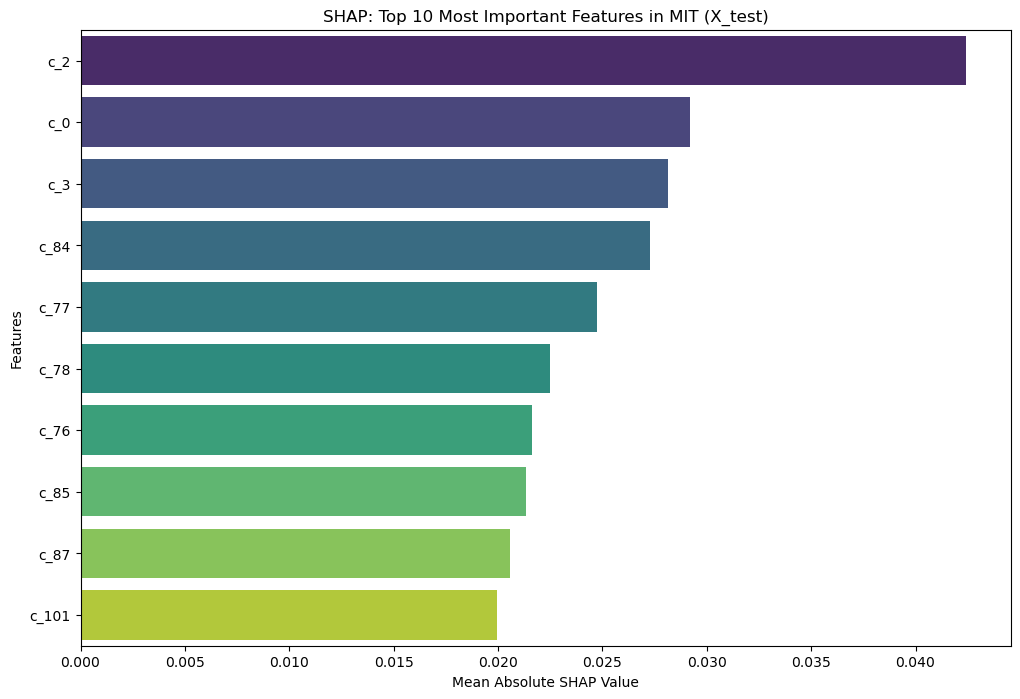

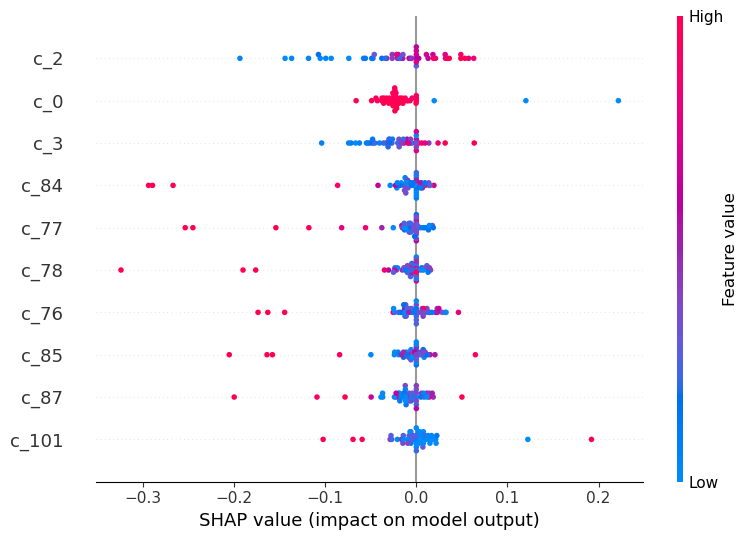

In [11]:
# Reduce data precision to save memory
X_train = X_train.astype(np.float32) # Reduce precision to 32-bit float to save memory
X_test = X_test.astype(np.float32) #32-bit float to save memory because the data is not very large

# Summarize the background data using k-means clustering to improve runtime efficiency
X_train_summary = shap.kmeans(X_train, 10)  # Summarize background to 10 clusters. Clusters are used to calculate SHAP values

# Initialize KernelExplainer using the summarized training dataset
explainer = shap.KernelExplainer(pipeline_model.named_steps['model'].predict, X_train_summary)

# Sample a smaller portion of X_test for SHAP calculations to handle memory limitations
X_test_sample = X_test.sample(n=50, random_state=42)  # Reduced `n` to 50 to handle memory and runtime issues

# Calculate SHAP values for the sample
shap_values_sample = explainer.shap_values(X_test_sample)

# Convert the SHAP values to a numpy array
shap_values_array = np.array(shap_values_sample)

# Calculate the mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values_array).mean(axis=0)

# Create a DataFrame to store feature importances
shap_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': mean_shap_values
})

# Sort the DataFrame based on feature importance
shap_importance_df = shap_importance_df.sort_values(by='importance', ascending=False)

# Display the top 10 most important features based on SHAP values
top_10_shap_features = shap_importance_df.head(10)
print("Top 10 most important features based on SHAP values:\n", top_10_shap_features)

# Plot the top 10 most important features based on SHAP values (bar chart)
plt.figure(figsize=(12, 8))
sns.barplot(
    x='importance', 
    y='feature', 
    data=top_10_shap_features, 
    palette='viridis'
)
plt.title('SHAP: Top 10 Most Important Features in MIT (X_test)')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.show()

# Plot a SHAP summary plot for the top 10 features (summary dot plot)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_sample, X_test_sample, plot_type="dot", max_display=10, feature_names=X_test.columns)


In [12]:
# Save the SHAP summary plot as an image
output_dir = os.path.join(os.getcwd(), 'images')
os.makedirs(output_dir, exist_ok=True)
shap.summary_plot(shap_values_sample, X_test_sample, plot_type="dot", max_display=10, feature_names=X_test.columns, show=False)
plt.savefig(os.path.join(output_dir, 'knn_shap_summary_plot.png'))
plt.close()

## LIME


True Label for selected instance: 0
Instance features:
 c_0      0.980392
c_1      0.696078
c_2      0.193627
c_3      0.009804
c_4      0.061275
           ...   
c_182    0.000000
c_183    0.000000
c_184    0.000000
c_185    0.000000
c_186    0.000000
Name: 200, Length: 187, dtype: float32


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre

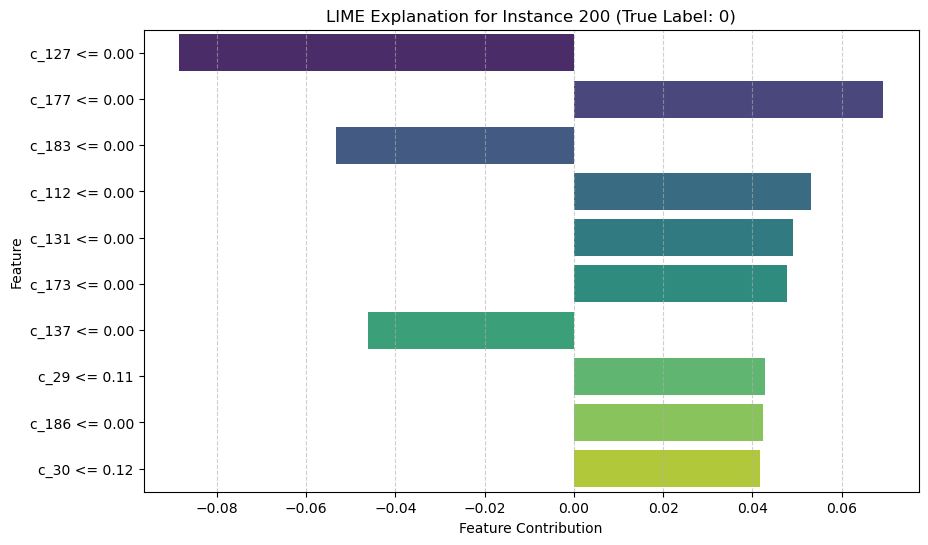

In [13]:
# load lime
import lime
import lime.lime_tabular


# Create a Lime Explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),  # Features from the training data
    training_labels=np.array(y_train),  # Target labels for training data
    mode="classification",  # Set to 'classification' or 'regression' based on your task
    feature_names=X_train.columns,  # Feature names
    class_names=['Class 0', 'Class 1'],  # Class names for binary classification (modify if more classes)
    discretize_continuous=True  # Discretizes continuous features for better explanation
)

# Select a random instance from the test set
idx = 200  ################################  You can change this index to select a different instance! ##############################
instance = X_test.iloc[idx]  # The input instance

# Get the true label for the selected instance
true_label = y_test.iloc[idx]

print("True Label for selected instance:", true_label)
print("Instance features:\n", instance)

# Explain the instance using the LIME explainer
exp = explainer.explain_instance(
    data_row=instance,  # Instance to explain
    predict_fn=pipeline_model.predict_proba,  # Prediction function from the model
    num_features=10  # Number of features to include in the explanation
)

# Extract feature contributions from the explanation object
feature_importance = exp.as_list()  # Returns a list of (feature, contribution) tuples

# Convert the feature importance to a DataFrame for easy visualization
lime_df = pd.DataFrame(feature_importance, columns=['Feature', 'Contribution'])

# Plot the LIME explanation using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Contribution', 
    y='Feature', 
    data=lime_df, 
    palette='viridis', 
    orient='h'
)
plt.title(f'LIME Explanation for Instance {idx} (True Label: {true_label})')
plt.xlabel('Feature Contribution')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [14]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())

Current time: 2024-11-13 10:03:43.743957
